# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 12, 48, 57, 770282)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login(project="lab1_mohamed_Emile")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1166484
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [13]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [14]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [15]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.050017E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [16]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,-2.15,0.1,26.161375,304.346161,stockholm
1,2024-11-22 00:00:00+00:00,-4.40,0.0,13.698934,266.987274,stockholm
2,2024-11-19 00:00:00+00:00,0.90,0.0,1.800000,143.130020,stockholm
3,2024-11-24 00:00:00+00:00,1.40,1.0,27.248455,136.605957,stockholm
4,2024-11-23 00:00:00+00:00,-4.25,0.0,7.517021,253.300674,stockholm
5,2024-11-25 00:00:00+00:00,0.95,0.4,16.323528,311.423584,stockholm
6,2024-11-26 00:00:00+00:00,2.00,0.6,20.771093,244.323227,stockholm
7,2024-11-20 00:00:00+00:00,1.45,0.0,22.197729,8.392845,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [17]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-21 00:00:00+00:00,-2.15,0.1,26.161375,304.346161,stockholm,0.488704
1,2024-11-22 00:00:00+00:00,-4.40,0.0,13.698934,266.987274,stockholm,1.561595
2,2024-11-19 00:00:00+00:00,0.90,0.0,1.800000,143.130020,stockholm,10.683678
3,2024-11-24 00:00:00+00:00,1.40,1.0,27.248455,136.605957,stockholm,6.617339
4,2024-11-23 00:00:00+00:00,-4.25,0.0,7.517021,253.300674,stockholm,6.024381
5,2024-11-25 00:00:00+00:00,0.95,0.4,16.323528,311.423584,stockholm,3.025390
6,2024-11-26 00:00:00+00:00,2.00,0.6,20.771093,244.323227,stockholm,1.592983
7,2024-11-20 00:00:00+00:00,1.45,0.0,22.197729,8.392845,stockholm,1.845211


In [18]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 416.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [19]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2024-11-19 00:00:00+00:00,0.90,0.0,1.800000,143.130020,stockholm,10.683678,stockholm-anders-lundstroms-gata,sweden,3
7,2024-11-20 00:00:00+00:00,1.45,0.0,22.197729,8.392845,stockholm,1.845211,stockholm-anders-lundstroms-gata,sweden,8
0,2024-11-21 00:00:00+00:00,-2.15,0.1,26.161375,304.346161,stockholm,0.488704,stockholm-anders-lundstroms-gata,sweden,1
1,2024-11-22 00:00:00+00:00,-4.40,0.0,13.698934,266.987274,stockholm,1.561595,stockholm-anders-lundstroms-gata,sweden,2
4,2024-11-23 00:00:00+00:00,-4.25,0.0,7.517021,253.300674,stockholm,6.024381,stockholm-anders-lundstroms-gata,sweden,5
3,2024-11-24 00:00:00+00:00,1.40,1.0,27.248455,136.605957,stockholm,6.617339,stockholm-anders-lundstroms-gata,sweden,4
5,2024-11-25 00:00:00+00:00,0.95,0.4,16.323528,311.423584,stockholm,3.025390,stockholm-anders-lundstroms-gata,sweden,6
6,2024-11-26 00:00:00+00:00,2.00,0.6,20.771093,244.323227,stockholm,1.592983,stockholm-anders-lundstroms-gata,sweden,7


In [20]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2 to 6
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   predicted_pm25               8 non-null      float32            
 7   street                       8 non-null      object             
 8   country                      8 non-null      object             
 9   days_before_forecast_day     8 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-18 01:35:56,168 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



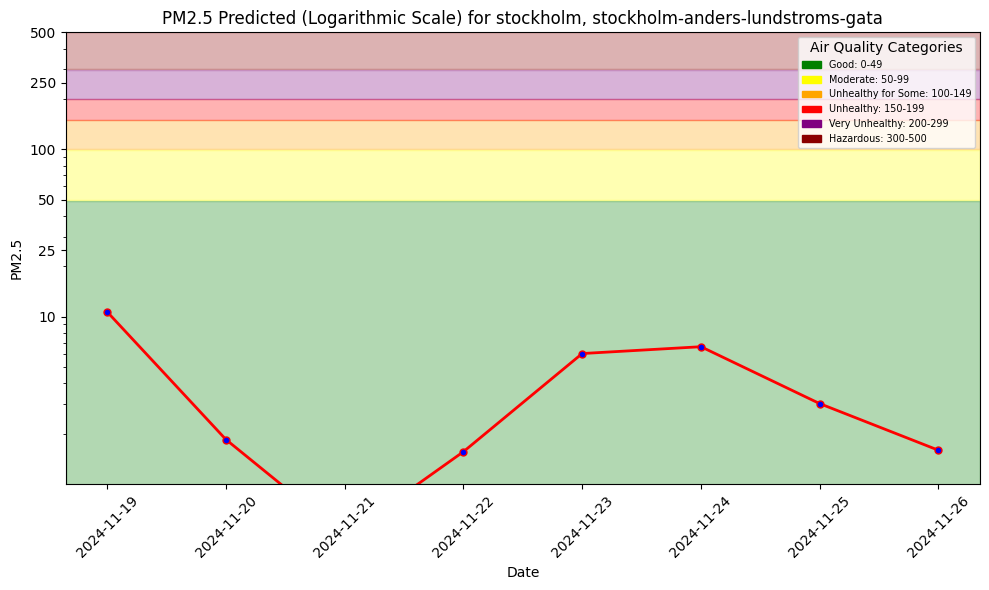

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [22]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [23]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1166484/fs/1157187/fg/1352042


Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1166484/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f90e44e9d20>, None)

In [24]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.20s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-2.15,0.1,26.161375,304.346161,stockholm,0.488704,stockholm-anders-lundstroms-gata,sweden,1


In [25]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,pm25,country,city,street,url
0,2021-11-09 00:00:00+00:00,1.60,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1,2020-12-22 00:00:00+00:00,4.83,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
2,2022-07-25 00:00:00+00:00,3.40,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
3,2023-06-07 00:00:00+00:00,0.80,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
4,2021-09-05 00:00:00+00:00,1.26,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
...,...,...,...,...,...,...
1776,2023-03-21 00:00:00+00:00,3.07,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1777,2023-02-01 00:00:00+00:00,2.13,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1778,2020-01-20 00:00:00+00:00,1.35,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1779,2021-09-15 00:00:00+00:00,0.90,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420


In [26]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1166484/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,2.65,0.0,12.371645,278.365784,stockholm,3.81314,1.0,stockholm-anders-lundstroms-gata,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

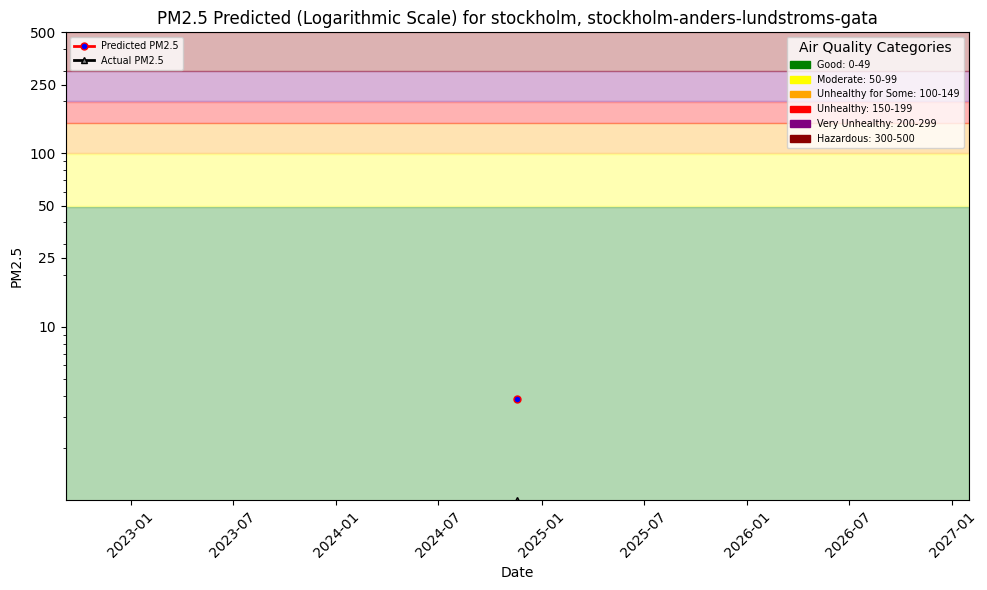

In [27]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---